In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import time
import random
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


<h3>Dataset creation</h3>

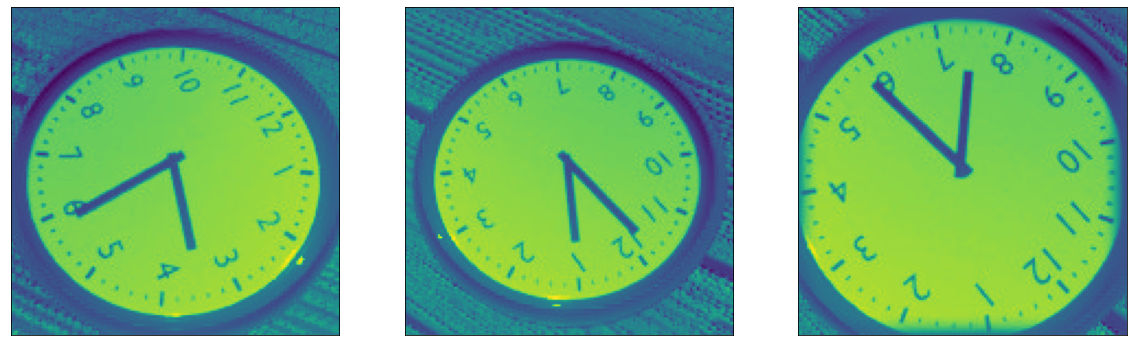

In [3]:
data = np.load("data/images.npy")
img = Image.fromarray(data[5229])
img_1 = Image.fromarray(data[1490])
img_2 = Image.fromarray(data[11234])
fig, axis = plt.subplots(1,3, figsize=(20,12))
axis[0].imshow(img)
axis[1].imshow(img_1)
axis[2].imshow(img_2)
for ax in axis:
    ax.set_xticks([])
    ax.set_yticks([])


In [4]:
# Load data
data = np.load("data/data_1.npy")
labels = np.load("data/labels_1.npy")

data = np.vstack((data,np.load("data/data_2.npy")))
labels = np.vstack((labels,np.load("data/labels_2.npy")))

data = np.vstack((data,np.load("data/data_3.npy")))
labels = np.vstack((labels,np.load("data/labels_3.npy")))

data = np.vstack((data,np.load("data/data_4.npy")))
labels = np.vstack((labels,np.load("data/labels_4.npy")))

data = np.vstack((data,np.load("data/data_5.npy")))
labels = np.vstack((labels,np.load("data/labels_5.npy")))


data = torch.FloatTensor(np.expand_dims(data,axis=1)/255.)
data_permuts = torch.randperm(data.shape[0])
data = data[data_permuts,:]
labels = torch.FloatTensor(labels)
labels = labels[data_permuts,:]

print(f"data: {data.shape}, labels: {labels.shape}")

data: torch.Size([18000, 1, 150, 150]), labels: torch.Size([18000, 2])


In [5]:
labels[0].shape

torch.Size([2])

In [6]:
class ClockDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [7]:
# Create main dataset
clock_dataset = ClockDataset(data, labels)
train_data, test_data, val_data = random_split(clock_dataset, [14000,3000,1000])

# Split dataset into train, test and validation sets
train_data = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = DataLoader(test_data, batch_size=64, shuffle=True)
val_data = DataLoader(val_data, batch_size=64, shuffle=True)

In [8]:
for X, y in train_data:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 150, 150])
Shape of y: torch.Size([64, 2]) torch.float32


<h3>Defining model</h3>

In [9]:
class NN_regression(nn.Module):
    """ Convolution model that returns one value as output.
    """
    def __init__(self, input_channels, h, w, n_outputs):
        super(NN_regression, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5, stride=2),
            nn.ReLU(),
        )
        self.hidden_layers = nn.Sequential(
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),

            nn.Flatten()
        )


        self.output_layer = nn.Sequential(
            nn.Linear(4608, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_outputs)
            
        )


    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x


<h3>Creating loss function</h3>

In [10]:
class CommonSenseError(nn.Module):
    def __init__(self):
        super(CommonSenseError, self).__init__()

    def forward(self, prediction, target):
        # hour common sense error in minutes
        preds = torch.floor(prediction.T)
        labels = target.T
        hour_start_idx = torch.minimum(preds[0], labels[0])
        hour_end_idx = torch.maximum(preds[0], labels[0])
        hour_dist_1 = (hour_end_idx - hour_start_idx)
        hour_dist_2 = hour_start_idx + 12 - hour_end_idx
        hour_dist = torch.minimum(hour_dist_1, hour_dist_2) * 60  # we want the common error to be in minutes

        # minutes common sense error
        mins_start_idx = torch.minimum(preds[1], labels[1])
        mins_end_idx = torch.maximum(preds[1], labels[1])
        mins_dist_1 = (mins_end_idx - mins_start_idx)
        mins_dist_2 = mins_start_idx + 60 - mins_end_idx
        mins_dist = torch.minimum(mins_dist_1, mins_dist_2)

        # return total common sense error in minutes
        return torch.mean(hour_dist + mins_dist)


a = torch.Tensor([[1,14], [4,28], [2,36], [1,1]])
b = torch.Tensor([[1,15], [3,29], [2,36], [11,59]])
cse = CommonSenseError()
cse.forward(a,b)

tensor(46.)

In [11]:
model = NN_regression(input_channels=1,h=150,w=150, n_outputs=2).to(device)
cse = CommonSenseError()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Train loss: {loss:>7f}")

In [13]:
def test(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss
    loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

In [14]:
epochs = 50
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_data, model, cse, optimizer)
    test(test_data, model, cse)
end_time = time.time()

Epoch 1
-------------------------------
Train loss: 187.645844
Test avg loss: 9215.640625 

Epoch 2
-------------------------------
Train loss: 193.333344
Test avg loss: 9220.560547 

Epoch 3
-------------------------------
Train loss: 190.208344
Test avg loss: 9221.951172 

Epoch 4
-------------------------------
Train loss: 175.937500
Test avg loss: 9219.131836 

Epoch 5
-------------------------------
Train loss: 191.062500
Test avg loss: 9216.571289 

Epoch 6
-------------------------------
Train loss: 192.708344
Test avg loss: 9218.333008 

Epoch 7
-------------------------------
Train loss: 199.041672
Test avg loss: 9217.477539 

Epoch 8
-------------------------------
Train loss: 186.062500
Test avg loss: 9216.000000 

Epoch 9
-------------------------------
Train loss: 196.479172
Test avg loss: 9218.661133 

Epoch 10
-------------------------------
Train loss: 198.541672
Test avg loss: 9222.770508 

Epoch 11
-------------------------------
Train loss: 166.875000
Test avg loss: 

In [ ]:
print(f"Done in {end_time - start_time}")

Done in 296.0589020252228
